Checking TF-IDF embedding...
Loaded cached TF-IDF embeddings.
Loading cached UMAP result...
UMAP result loaded.
Loading cached KMeans results...


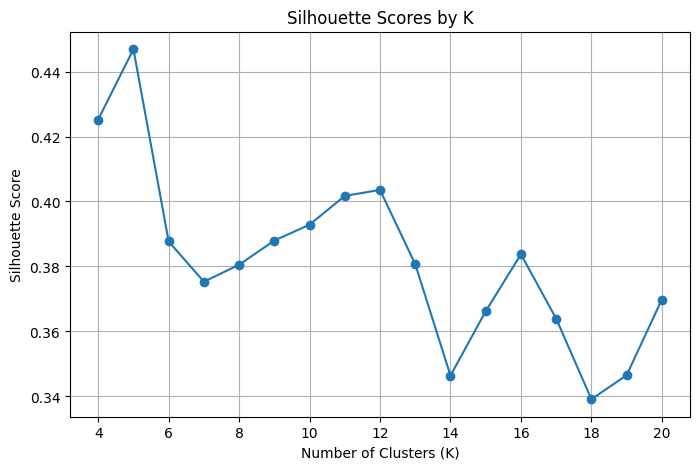

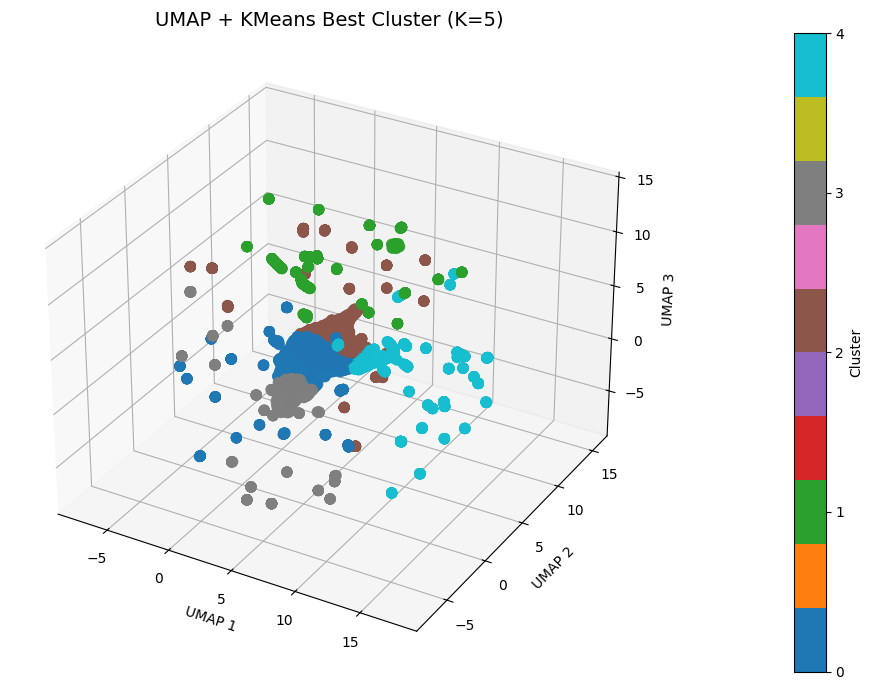

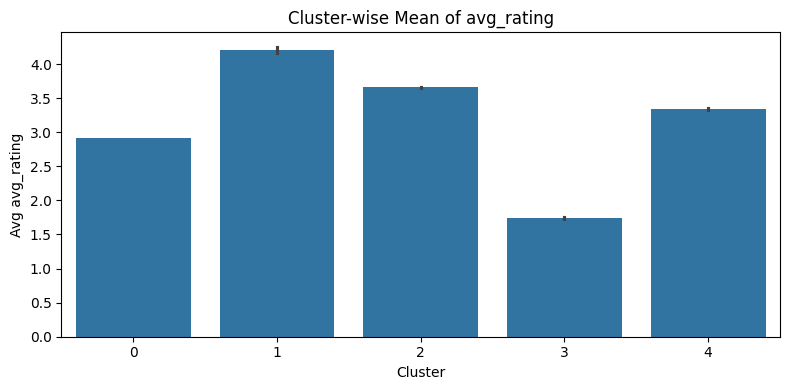

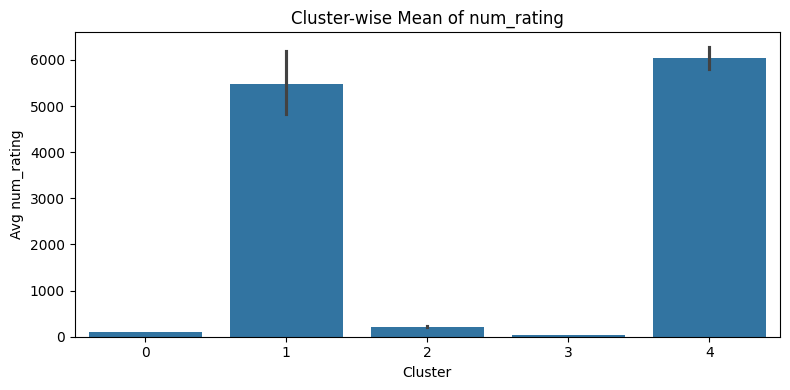

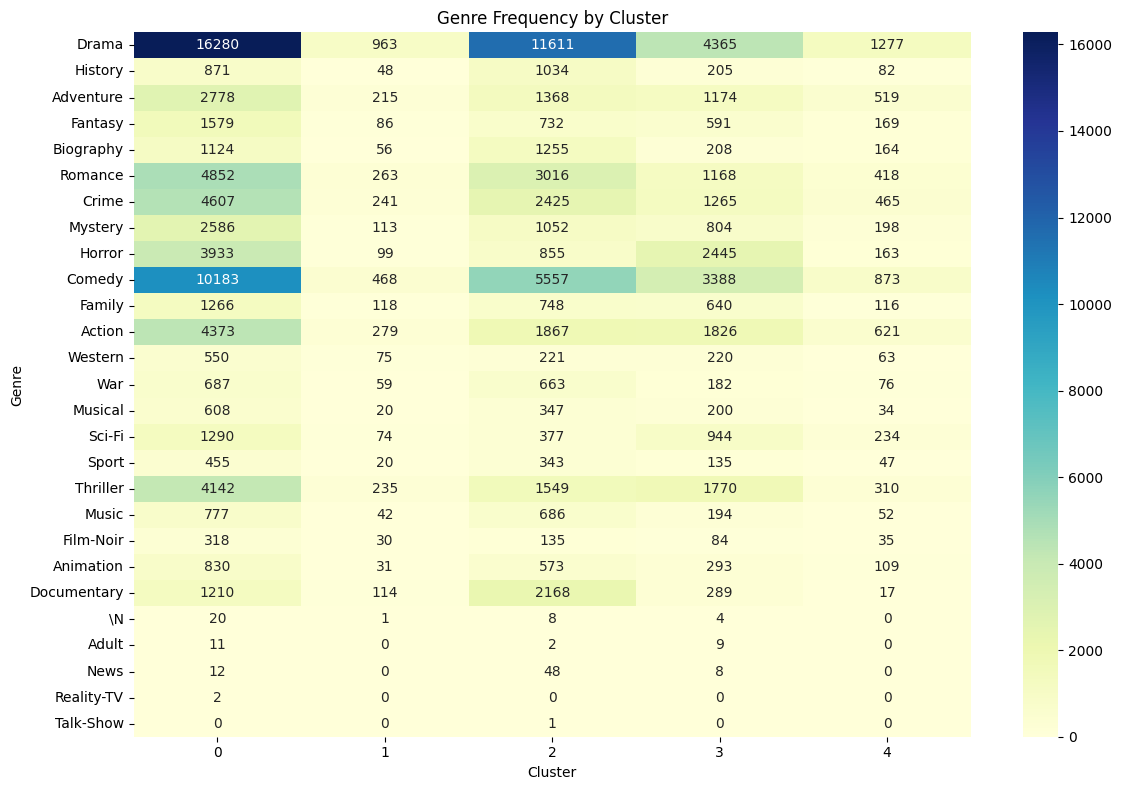


Cluster Summary: Average Rating / Total Number of Ratings
         avg_rating  num_rating
cluster                        
0              2.91   3130631.0
1              4.21   9168236.0
2              3.66   3997948.0
3              1.74    383390.0
4              3.34  14240554.0

Top 5 Movies by Number of Ratings per Cluster:

Cluster 0
- The Devil's Own (Rating: 3.03, Num Ratings: 3786, Genres: Action,Crime,Drama)
- The Brothers Grimm (Rating: 2.92, Num Ratings: 3744, Genres: Action,Adventure,Comedy)
- National Lampoon's European Vacation (Rating: 2.98, Num Ratings: 3742, Genres: Adventure,Comedy)
- Paranormal Activity (Rating: 3.00, Num Ratings: 3735, Genres: Horror,Mystery)
- Not Another Teen Movie (Rating: 2.66, Num Ratings: 3726, Genres: Comedy)

Cluster 1
- The Shawshank Redemption (Rating: 4.40, Num Ratings: 102929, Genres: Drama)
- Forrest Gump (Rating: 4.05, Num Ratings: 100296, Genres: Drama,Romance)
- Pulp Fiction (Rating: 4.20, Num Ratings: 98409, Genres: Crime,Drama)
- 

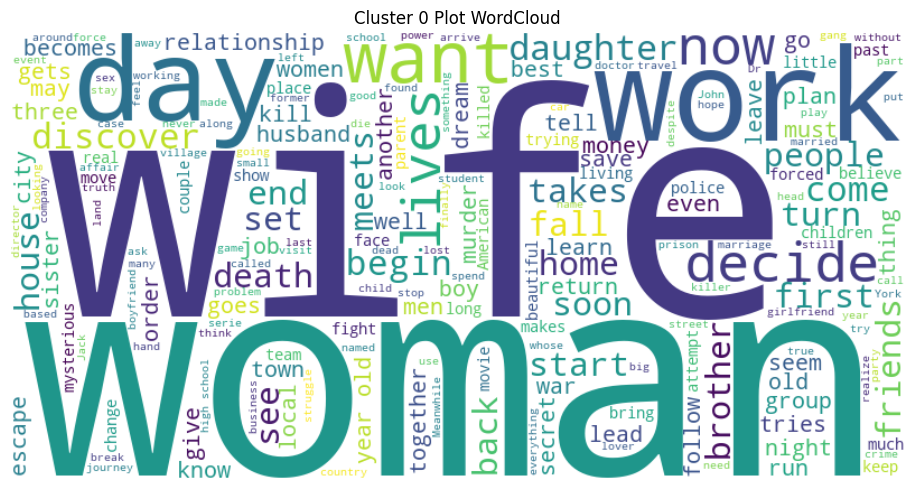

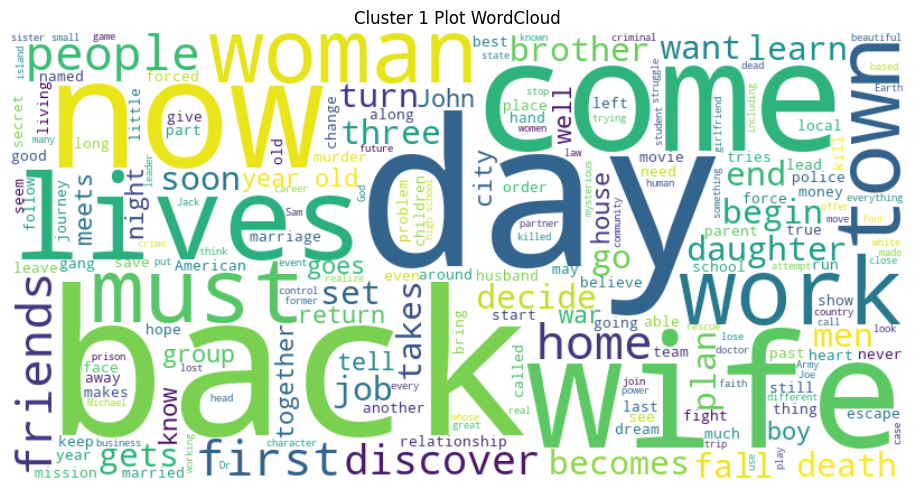

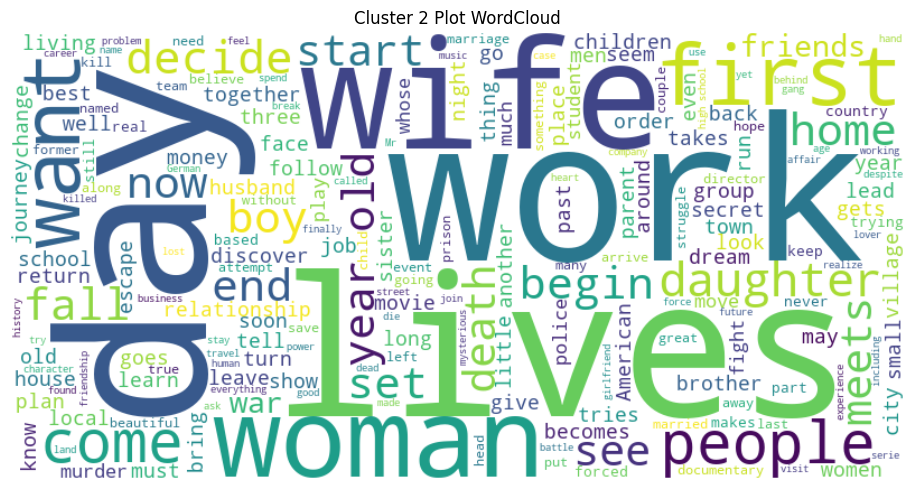

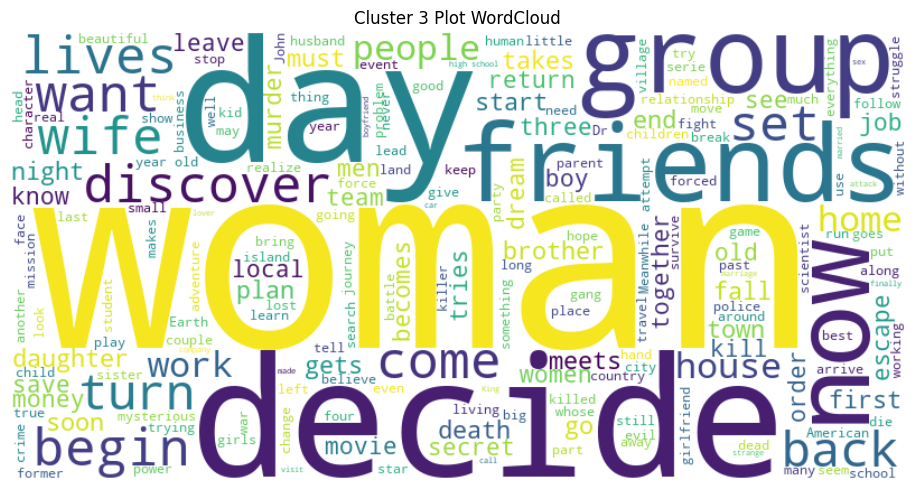

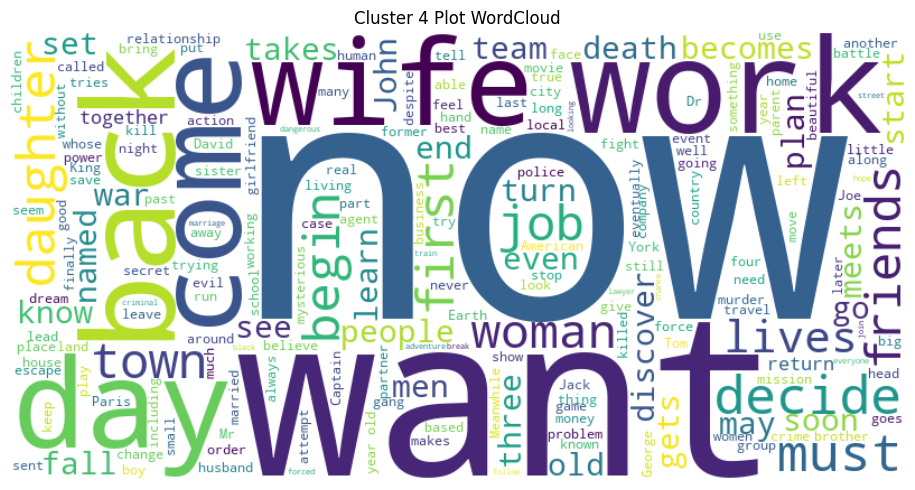

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from scipy.sparse import hstack, csr_matrix, save_npz, load_npz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import joblib
import umap

# Suppress warnings
warnings.filterwarnings("ignore", message=".*n_jobs value 1 overridden to 1 by setting random_state.*")
warnings.filterwarnings("ignore", message=".*Trying to unpickle estimator.*")



def load_data(filepath):
    return pd.read_csv(filepath, encoding="ISO-8859-1")


def multi_hot_encode_with_others(df, column, top_k=None):
    df[column + '_list'] = df[column].fillna('').apply(lambda x: [s.strip() for s in x.split(',') if s.strip()])
    all_items = df[column + '_list'].explode()
    top_items = all_items.value_counts().nlargest(top_k).index if top_k else all_items.unique()
    df[column + '_filtered'] = df[column + '_list'].apply(
        lambda items: [item if item in top_items else 'others' for item in items]
    )
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(df[column + '_filtered'])
    return csr_matrix(encoded), mlb.classes_


def get_tfidf_embeddings(df, max_features=5000,
                         tfidf_embed_file="plot_tfidf_embeddings.npz",
                         tfidf_vectorizer_file="plot_tfidf_vectorizer.pkl"):
    print("Checking TF-IDF embedding...")

    if os.path.exists(tfidf_embed_file) and os.path.exists(tfidf_vectorizer_file):
        plot_embeddings = load_npz(tfidf_embed_file)
        tfidf_vectorizer = joblib.load(tfidf_vectorizer_file)
        print("Loaded cached TF-IDF embeddings.")
    else:
        tfidf_vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
        plot_texts = df["plot"].fillna("")
        plot_embeddings = tfidf_vectorizer.fit_transform(plot_texts)
        save_npz(tfidf_embed_file, plot_embeddings)
        joblib.dump(tfidf_vectorizer, tfidf_vectorizer_file)
        print("TF-IDF embeddings computed and saved.")

    return plot_embeddings, tfidf_vectorizer


def build_feature_matrix(df, plot_embeddings, actor_encoded, director_encoded):
    numeric_features = df[['avg_rating', 'num_rating']].fillna(0)
    scaler = StandardScaler()
    scaled_numeric = scaler.fit_transform(numeric_features)
    return hstack([plot_embeddings, actor_encoded, director_encoded, csr_matrix(scaled_numeric)])


def reduce_dimensions(X, n_neighbors=15, min_dist=0.1, random_state=42, umap_file="X_umap_3d.npy"):
    if os.path.exists(umap_file):
        print("Loading cached UMAP result...")
        X_umap = np.load(umap_file)
        print("UMAP result loaded.")
    else:
        print("Performing UMAP dimensionality reduction...")
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
        X_dense = X.toarray() if hasattr(X, "toarray") else X
        X_umap = reducer.fit_transform(X_dense)
        np.save(umap_file, X_umap)
        print(f"UMAP result saved to: {umap_file}")
    return X_umap


def find_best_k(X, k_range=range(3, 9),
                kmeans_cache_file="kmeans_labels_3d.npy",
                silhouette_cache_file="kmeans_silhouette_scores_3d.pkl"):
    if os.path.exists(kmeans_cache_file) and os.path.exists(silhouette_cache_file):
        print("Loading cached KMeans results...")
        best_labels = np.load(kmeans_cache_file)
        k_list, score_list = joblib.load(silhouette_cache_file)
        best_k = k_list[np.argmax(score_list)]
        best_score = max(score_list)
    else:
        print("Evaluating silhouette scores:")
        best_k = None
        best_score = -1
        k_list = []
        score_list = []

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            cluster_labels = kmeans.fit_predict(X)
            score = silhouette_score(X, cluster_labels)

            k_list.append(k)
            score_list.append(score)

            print(f"K={k}: Silhouette Score = {score:.4f}")
            if score > best_score:
                best_score = score
                best_k = k
                best_labels = cluster_labels

        np.save(kmeans_cache_file, best_labels)
        joblib.dump((k_list, score_list), silhouette_cache_file)

    return best_k, best_labels, k_list, score_list


def plot_silhouette_scores(k_list, score_list):
    plt.figure(figsize=(8, 5))
    plt.plot(k_list, score_list, marker='o', linestyle='-')
    plt.title("Silhouette Scores by K")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.show()



def visualize_clusters(X_umap, labels, k):
    df_vis = pd.DataFrame(X_umap, columns=["UMAP 1", "UMAP 2", "UMAP 3"])
    df_vis["Cluster"] = labels

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(
        df_vis["UMAP 1"],
        df_vis["UMAP 2"],
        df_vis["UMAP 3"],
        c=df_vis["Cluster"],
        cmap='tab10',
        s=50,
        alpha=0.8
    )

    ax.set_title(f"UMAP + KMeans Best Cluster (K={k})", fontsize=14)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.set_zlabel("UMAP 3")

    norm = mcolors.Normalize(vmin=min(labels), vmax=max(labels))
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(cmap='tab10', norm=norm),
        ax=ax,
        pad=0.15,
        ticks=np.arange(k),
        label='Cluster'
    )

    plt.tight_layout()
    plt.show()


def summarize_clusters(df):
    print("\nCluster Summary: Average Rating / Total Number of Ratings")
    cluster_stats = df.groupby("cluster").agg({
        "avg_rating": "mean",
        "num_rating": "sum"
    }).round(2)
    print(cluster_stats)

    print("\nTop 5 Movies by Number of Ratings per Cluster:")
    for cluster_id in sorted(df["cluster"].unique()):
        print(f"\nCluster {cluster_id}")
        cluster_movies = df[df["cluster"] == cluster_id]
        top5 = cluster_movies.sort_values(by="num_rating", ascending=False).head(5)
        for idx, row in top5.iterrows():
            print(f"- {row['primaryTitle']} (Rating: {row['avg_rating']:.2f}, Num Ratings: {int(row['num_rating'])}, Genres: {row['genres']})")

    print("\nTop 3 Genres per Cluster:")
    for cluster_id in sorted(df["cluster"].unique()):
        cluster_genres = df[df["cluster"] == cluster_id]["genres"].dropna().tolist()
        all_genres = [g.strip() for genres in cluster_genres for g in genres.split(",")]
        top_genres = Counter(all_genres).most_common(3)
        genre_str = ", ".join([f"{g}({c})" for g, c in top_genres]) if top_genres else "None"
        print(f"Cluster {cluster_id} Top Genres: {genre_str}")

    print("\nMost Representative Genre (excluding Drama and Comedy):")
    excluded = {"Drama", "Comedy"}
    for cluster_id in sorted(df["cluster"].unique()):
        cluster_genres = df[df["cluster"] == cluster_id]["genres"].dropna().tolist()
        all_genres = [g.strip() for genres in cluster_genres for g in genres.split(",") if g.strip() not in excluded]
        top_genre = Counter(all_genres).most_common(1)
        genre_str = top_genre[0][0] if top_genre else "None"
        print(f"Cluster {cluster_id} Representative Genre: {genre_str}")

    print("\nTop Directors and Actors per Cluster:")
    for cluster_id in sorted(df["cluster"].unique()):
        print(f"\nCluster {cluster_id}")
        cluster_df = df[df["cluster"] == cluster_id]
        directors = [d.strip() for dir_list in cluster_df["director"].dropna() for d in dir_list.split(",")]
        top_directors = Counter(directors).most_common(3)
        director_str = ", ".join([f"{name}({cnt})" for name, cnt in top_directors]) if top_directors else "No info"
        print(f"Top 3 Directors: {director_str}")
        actors = [a.strip() for actor_list in cluster_df["actors"].dropna() for a in actor_list.split(",")]
        top_actors = Counter(actors).most_common(5)
        actor_str = ", ".join([f"{name}({cnt})" for name, cnt in top_actors]) if top_actors else "No info"
        print(f"Top 5 Actors: {actor_str}")

    print("\nTop 3 Release Years per Cluster:")
    df[['runtimeMinutes', 'startYear']] = df[['runtimeMinutes', 'startYear']].replace('\\N', np.nan)
    df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce').fillna(df['runtimeMinutes'].median())
    df['startYear'] = pd.to_numeric(df['startYear'], errors='coerce').fillna(df['startYear'].median())
    for cluster_id in sorted(df["cluster"].unique()):
        years = df[df["cluster"] == cluster_id]["startYear"].dropna().astype(int)
        top_years = Counter(years).most_common(3)
        year_str = ", ".join([f"{year} ({count} films)" for year, count in top_years]) if top_years else "No info"
        print(f"Cluster {cluster_id}: {year_str}")

    print("\nTop 3 Languages and Countries per Cluster:")
    for cluster_id in sorted(df["cluster"].unique()):
        cluster_df = df[df["cluster"] == cluster_id]
        languages = [l.strip() for lang in cluster_df["language"].dropna() for l in lang.split(",")]
        top_langs = Counter(languages).most_common(3)
        lang_str = ", ".join([f"{l}({c})" for l, c in top_langs]) if top_langs else "No info"
        countries = [c.strip() for country in cluster_df["country"].dropna() for c in country.split(",")]
        top_countries = Counter(countries).most_common(3)
        country_str = ", ".join([f"{c}({cnt})" for c, cnt in top_countries]) if top_countries else "No info"
        print(f"Cluster {cluster_id} - Languages: {lang_str} | Countries: {country_str}")

    print("\nPlot WordCloud per Cluster:")
    stopwords = set(STOPWORDS)
    stopwords.update(["find", "one", "will", "life", "take", "family", "love", "man", "two", "father", "new", "live", "world", "friend", "become",
                 "young", "help", "meet", "story", "time", "make", "film", "mother", "finds", "girl", "way", "son"])
    for cluster_id in sorted(df["cluster"].unique()):
        texts = df[df["cluster"] == cluster_id]["plot"].fillna("").str.cat(sep=" ")
        wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords).generate(texts)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Cluster {cluster_id} Plot WordCloud")
        plt.tight_layout()
        plt.show()

def plot_cluster_feature_distributions(df):
    features = ['avg_rating', 'num_rating']
    for feature in features:
        plt.figure(figsize=(8, 4))
        sns.barplot(data=df, x='cluster', y=feature, estimator=np.mean)
        plt.title(f'Cluster-wise Mean of {feature}')
        plt.ylabel(f'Avg {feature}')
        plt.xlabel('Cluster')
        plt.tight_layout()
        plt.show()


def plot_genre_heatmap(df):
    genre_counts = {}
    for cluster_id in sorted(df["cluster"].unique()):
        genres = df[df["cluster"] == cluster_id]["genres"].dropna()
        genre_list = [g.strip() for gl in genres for g in gl.split(",")]
        count = Counter(genre_list)
        genre_counts[cluster_id] = count

    genre_df = pd.DataFrame(genre_counts).fillna(0).astype(int)
    plt.figure(figsize=(12, 8))
    sns.heatmap(genre_df, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("Genre Frequency by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Genre")
    plt.tight_layout()
    plt.show()



def main():
    df = load_data("../1. Data_preparation/df_final_frozen_62188.csv")
    # df = load_data("df_final.csv")
    plot_embeddings, _ = get_tfidf_embeddings(df)
    actor_encoded, _ = multi_hot_encode_with_others(df, 'actors', top_k=50)
    director_encoded, _ = multi_hot_encode_with_others(df, 'director', top_k=20)
    X = build_feature_matrix(df, plot_embeddings, actor_encoded, director_encoded)
    X_umap = reduce_dimensions(X)
    best_k, best_labels, k_list, score_list = find_best_k(X_umap)
    plot_silhouette_scores(k_list, score_list)
    df['cluster'] = best_labels
    visualize_clusters(X_umap, best_labels, best_k)
    plot_cluster_feature_distributions(df)    
    plot_genre_heatmap(df)

    summarize_clusters(df)


if __name__ == "__main__":
    main()
